<a href="https://colab.research.google.com/github/Re14m/isk/blob/master/2022_03_21_recipie397.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ライブラリのインストール
!pip install tensorflow

In [ ]:
# コーパス
corpus = [
    "dog is a canine",
    "canine is a mammal",
    "mammal is an animal",
    "animal is a living thing",
    "living thing is a thing",
    "bulldog is a dog",
    "kitty is a cat",
    "cat is a mammal",
]

In [ ]:
# テキストの前処理を実施（stopwords）
def remove_stop_words(corpus):
    stop_words = ["is", "a", "an", "will", "be"]
    results = []
    for text in corpus:
        tmp = text.split(" ")
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))

    return results


corpus = remove_stop_words(corpus)
corpus

['dog canine',
 'canine mammal',
 'mammal animal',
 'animal living thing',
 'living thing thing',
 'bulldog dog',
 'kitty cat',
 'cat mammal']

In [ ]:
# 単語ごとに分割（stopwords）
words = []
for text in corpus:
    for word in text.split(" "):
        words.append(word)

words = set(words)
words

{'animal',
 'bulldog',
 'canine',
 'cat',
 'dog',
 'kitty',
 'living',
 'mammal',
 'thing'}

In [ ]:
# 近傍に出現する単語のカウント（Skip-Gram）
word_to_id = {}
for i, word in enumerate(words):
    word_to_id[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())

window_size = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[
            max(idx - window_size, 0) : min(idx + window_size, len(sentence)) + 1
        ]:
            if neighbor != word:
                data.append([word, neighbor])

import pandas as pd

df = pd.DataFrame(data, columns=["input", "label"])
print(df)

      input    label
0       dog   canine
1    canine      dog
2    canine   mammal
3    mammal   canine
4    mammal   animal
5    animal   mammal
6    animal   living
7    animal    thing
8    living   animal
9    living    thing
10    thing   animal
11    thing   living
12   living    thing
13   living    thing
14    thing   living
15    thing   living
16  bulldog      dog
17      dog  bulldog
18    kitty      cat
19      cat    kitty
20      cat   mammal
21   mammal      cat


In [ ]:
# datasetの作成
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np

ONE_HOT_DIM = len(words)

def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = []
Y = []

for x, y in zip(df["input"], df["label"]):
    X.append(to_one_hot_encoding(word_to_id[x]))
    Y.append(to_one_hot_encoding(word_to_id[y]))

X_train = np.asarray(X)
Y_train = np.asarray(Y)

print(word_to_id)
print(X_train)
print(Y_train)

Instructions for updating:
non-resource variables are not supported in the long term
{'living': 0, 'mammal': 1, 'dog': 2, 'thing': 3, 'animal': 4, 'bulldog': 5, 'kitty': 6, 'canine': 7, 'cat': 8}
[[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 

In [ ]:
# モデル構築・学習
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
EMBEDDING_DIM = 2

w1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1]))
hidden_layer = tf.add(tf.matmul(x, w1), b1)

w2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add(tf.matmul(hidden_layer, w2), b2))

loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

iteration = 20000
for i in range(iteration):
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print(
            "iteration " + str(i) + " loss is : ",
            sess.run(loss, feed_dict={x: X_train, y_label: Y_train}),
        )
vectors = sess.run(w1 + b1)
w2v_df = pd.DataFrame(vectors, columns=["x1", "x2"])
w2v_df["word"] = list(words)
w2v_df = w2v_df[["word", "x1", "x2"]]
w2v_df

iteration 0 loss is :  2.7183752
iteration 3000 loss is :  0.94250053
iteration 6000 loss is :  0.8805217
iteration 9000 loss is :  0.86111474
iteration 12000 loss is :  0.85075015
iteration 15000 loss is :  0.8439869
iteration 18000 loss is :  0.8391023


,word,x1,x2
0,living,2.656654,-4.568478
1,mammal,0.651545,-0.402884
2,dog,2.041507,2.567160
3,thing,-4.037252,-4.792740
4,animal,-0.441267,-0.370155
5,bulldog,-5.426080,-2.027632
6,kitty,4.167362,-2.817626
7,canine,-3.389446,0.446383
8,cat,-2.492306,3.857549


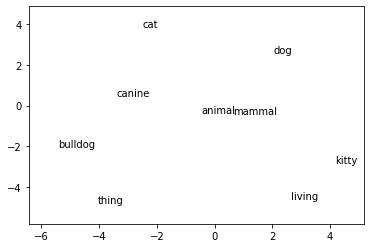

In [ ]:
# 可視化（word2vec）
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df["word"], w2v_df["x1"], w2v_df["x2"]):
    ax.annotate(word, (x1, x2))

PADDING = 1.0

x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)
plt.rcParams["figure.figsize"] = (10, 10)

plt.show()